# Motion Analysis using python OpenCV

A ***Analise de Movimentos***(Motion Analysis - MA) é uma forma de automatizar a quantificação de movimento presente em individuos. Essa estimativa é muito complexa e longa para ser feita sem um processo automatizado além de gerar viéses caso não seja feita de forma objetiva. A medida de um indicador de movimento para cada participante de um estudo pode ser muito útil, tanto como uma váriavel comportamental não verbal, como um indicador que pode explicar resultados obtidos por ferramentas de monitoramento como o EEG ou o FNIRS. Este projeto de teve como objetivo desenvolver um código para MA de músicos durante performance musical em conjunto a partir de gravações em vídeo. 
Pretende-se avaliar a viabilidade da metodologia para a quantificação de artefatos de movimentos durante experimentos com fNIRS hyperscanning, além de tentar avaliar como a série de movimentos de um músico influenciou a série de movimentos de sua respectiva dupla.


Normalmente os Métodos de MEA se baseiam em frame-difference analysis em que os vídeos são analisados quadro x quadro, quantificando a diferença de algum parametro entre esses quadros, além disso essas diferenças devem estar definidas dentro de uma região de interesse (ROI). No artigo [Ramseyer, F. T. (2020)](https://www.researchgate.net/publication/342664554_Motion_energy_analysis_MEA_A_primer_on_the_assessment_of_motion_from_video)
está disponivel a descrição de uma ferramenta de MEA desenvolvida para facilitar o processo de automatização dessa váriavel em estudos cientificos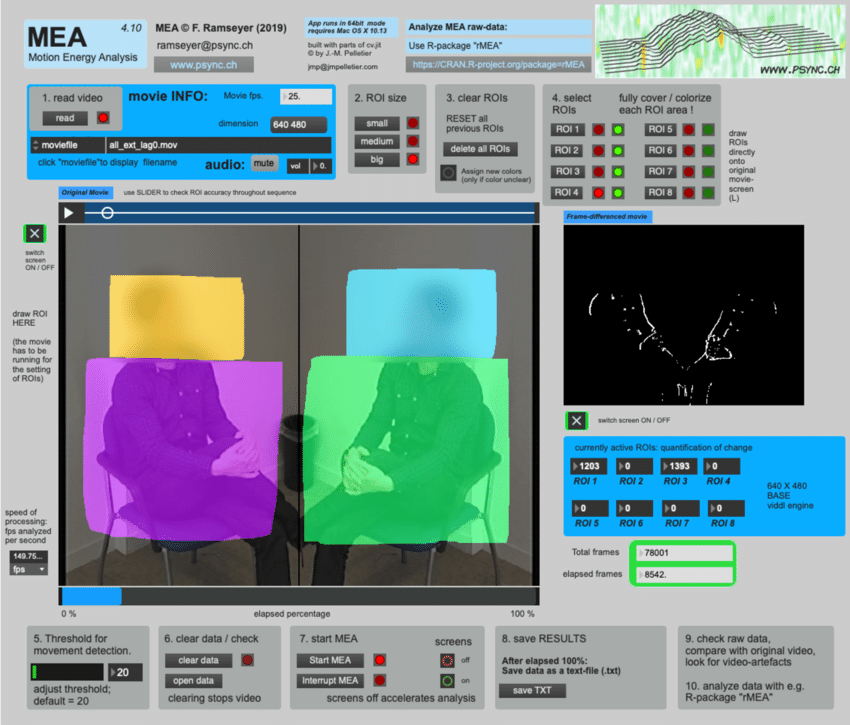

Essa ferramenta é muito útil para estudos em que a quantidade de movimento seja menor e as posições dos envolvidos não fiquem variando muito (ela foi pensada para interações entre psicologos e pacientes).O que não se aplica na necessidade de avaliar o movimento em músicos, que é bem mais dinâmico. Devido a essa movimentação é difícil estabecer um ROI assertivo para cada participante. O ROI para a analise precisa ser a cabeça do participante.


Para solucionar essa questão se utilizou uma ferramenta disponível dentro do pacote OpenCV do Python, que um Modelo de Aprendizado de Maquina é utilizado para encontrar um rosto dentro de uma imagem, após encontrar o rosto é salva a posição do centro do rosto, e frame a frame é possível cálcular a distância euclidiana do centro de um rosto com essa ferramenta.
Esses dados podem ser salvos e gerar uma série temporal com as distancias frame a frame de cada rosto, servindo como um indicador de MEA.

O fluxo de tratamento dos dados do código é o seguinte:

    - Importa as informações e bibliotecas
    - Carrega o modelo de reconhecimento de faces
    - Corta o vídeo analisado em duas parte (uma parte para cada participante)
    - Avalia e guarda a posição de cada rosto em cada vídeo
    - Calcula a distância euclidiana da posição atual com o frame anterior
    - Avalia se a distância obtidade não está acima de um parametro inicial
    - Salva a distância obtida em cada frame em uma série temporal
    - Realiza a padronização dos dados
    - Exporta as informações em um Dataframe

O código foi aplicado sobre 7 vídeos de 4 Duplas de músicos. Para aplicar a análise o código foi separado em duas partes, a primeira com as funções que foram criadas para elaborar o tratamento dos vídeos e o segundo para aplicar essas funções na sequencia de arquivos.

O primeiro é o código **"analise_videos.py"** e o segundo é o **"Aplica_Modelo.py"**

**analise_videos.py**

In [64]:
# importa as bibiotecas:
# Pandas - para o tratamento de dataframes
import pandas as pd
# Numpy - para o tratamento de matrizes e funções matemáticas
import numpy as np
# Matplotlib e Seaborn para geração de gráficos
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns 
#glob e os para manipulação de caminhos e arquivos
#datetime - para tratamento de data e hora
import glob, os , datetime
#Imutils - para o reshape de imagens e tratamento de matrizes
import imutils
# Scipy.spatial para o uso da função de distância euclidiana
from scipy.spatial import distance
# OpenCV - para tratamento de imagens e aplicação do modelo
import cv2
# TQDM - Para o acompanhamento visual da execução do código
from tqdm import tqdm
# Sklearn.preprocessing - para o escalonamento dos dados após aplicação do modelo
from sklearn.preprocessing import MinMaxScaler


In [3]:
# No inicio do código é importado um modelo treinado para reconhecimento de Faces - Esse é um modelo de Deep Learning,
#para mais informações sobre esse tipo de modelo é possivel consultar as descrições 
#em https://docs.opencv.org/4.x/d2/d58/tutorial_table_of_content_dnn.html

net = cv2.dnn.readNetFromCaffe("deploy.prototxt.txt", "res10_300x300_ssd_iter_140000.caffemodel")



In [ ]:
# Primeira Função, tem como objetivo encontrar o rosto mais provavel dentro de uma imagem, encontrar o centro do rosto,
# e devolver a distância euclidiana com a posição do frame anterior

# frame - Uma imagem
# motion - um vetor com a serie de distâncias
# previous_frame - uma dupla de posições (a,b), quando é a primeira imagem o previous_frame é definido com (0,0)
# param_lim - Um parametro limite que evita ruídos nos dados

def aplica_rede(frame,motion,previous_frame,param_lim):
    #Captura o shape do vídeo
    (h, w) = frame.shape[:2]
    # Aplica o Modelo sobre a imagem, a imagem sofre um tratamento para sempre estar no mesmo tamanho
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    #Rostos encontrados
    detections = net.forward()
    # desenha uma caixa com o a posição da detecção mais provavel de ser um rosto
    box = detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
    
    (startX, startY, endX, endY) = box.astype("int")
 
    text = "{:.2f}%".format(detections[0, 0, 0, 2] * 100)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.rectangle(frame, (startX, startY), (endX, endY),(0, 0, 255), 2)
    
    #define o centro o rosto a partir das coordenadas da caixa
    centroid = (sum([startX, endX]) / 2, sum([startY, endY]) / 2)
    # desenha o centroid e recalcula o limite
    if centroid[0]>0 and centroid[1]>0:
        cv2.circle(frame, (int(centroid[0]),int(centroid[1])), radius=10, color=(0, 0, 255), thickness=-1)
        if len(motion)>1:

            limite = int((1+param_lim)*motion[:-1][0])
            #limite_inf = int((1-0.15)*motion[:-1][0])
        else:
            limite=350
            #limite_inf = 0
    # caso a distância esteja dentro do limite calcula a distância
        if distance.euclidean(previous_frame, centroid)<limite: #and distance.euclidean(previous_frame, centroid)>limite_inf :
            motion.append(distance.euclidean(previous_frame, centroid))
            previous_frame = centroid
        # elif distance.euclidean(previous_frame, centroid)<limite:
        #     motion.append(limite_inf)
        #     previous_frame = centroid

        else:
        # caso contrario limita a distância ao limite
            motion.append(limite)#apendar um np.nan
            previous_frame = centroid
    else:
        motion.append(distance.euclidean(previous_frame, previous_frame))
        previous_frame = previous_frame
        
        
    # marca a prob do rosto
    cv2.putText(frame, text, (startX, y),
                # marcar a probabilidade em serie
    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    
    # retorna as informações
    return frame,motion,previous_frame




In [ ]:
# as funções de analise de video fazem a mesma coisa porém uma exibe na tela e a outra não (mais util para analise por ir mais rápido)

def analise_video(local_video,tamanho=800,param_lim=0.15,imshow=False):
    if imshow == True:
        cap = cv2.VideoCapture(local_video)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print( length )

        motion_right=[]
        motion_left=[]
        previousframe_right=(0,0)
        previousframe_left=(0,0)

        for i in tqdm(range(length)):
            ret, frame = cap.read()
            frame = imutils.resize(frame, width=tamanho)
            height, width, ch = frame.shape

            roi_height = height 
            roi_width = int(tamanho/2)
            frame[0:roi_height, 0:roi_width]

            images = [frame[0:roi_height, 0:roi_width],frame[0:roi_height, roi_width:2*roi_width]]

            imagem_right,motion_right,previousframe = aplica_rede(images[0],motion_right,previousframe_right,param_lim)
            imagem_left,motion_left,previousframe = aplica_rede(images[1],motion_left,previousframe_left,param_lim)

            cv2.imshow("Frame - Right",imagem_right )
            plt.clf()
            plt.plot(motion_right)
            plt.savefig('temp_right.png')
            img1 = cv2.imread('temp_right.png')
            cv2.moveWindow("Frame - Right", roi_width-int(tamanho/4),0)
            cv2.imshow("Plot1",imutils.resize(img1, width=300))
            cv2.moveWindow("Plot1", 250,500)
            cv2.imshow("Frame - Left", imagem_left)
            plt.clf()
            plt.plot(motion_left)
            plt.savefig('temp_left.png')
            img2 = cv2.imread('temp_left.png')
            cv2.imshow("Plot2",imutils.resize(img2, width=300))
            cv2.moveWindow("Plot2", 650,500)

            cv2.moveWindow("Frame - Left", roi_width+int(tamanho/4),0)



            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

        df = pd.DataFrame()
        df["motion_right"] = motion_right
        df["motion_left"] = motion_left
        list1 = [i for i in df['motion_right'].values]
        list2 = [i for i in df['motion_left'].values]
        lista_fim = list1 + list2
        scaler = MinMaxScaler().fit(pd.DataFrame(lista_fim))

        df["motion_right_scaled"] = scaler.transform(df[['motion_right']])
        df["motion_left_scaled"] = scaler.transform(df[['motion_left']])



        return df
    
    else:        
        cap = cv2.VideoCapture(local_video)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print( length )

        motion_right=[]
        motion_left=[]
        previousframe_right=(0,0)
        previousframe_left=(0,0)

        for i in tqdm(range(length)):
            # Captura frame-por-frame
            ret, frame = cap.read()
            frame = imutils.resize(frame, width=tamanho)
            height, width, ch = frame.shape

            roi_height = height 
            roi_width = int(tamanho/2)
            frame[0:roi_height, 0:roi_width]

            images = [frame[0:roi_height, 0:roi_width],frame[0:roi_height, roi_width:2*roi_width]]

            imagem_right,motion_right,previousframe = aplica_rede(images[0],motion_right,previousframe_right,param_lim)
            imagem_left,motion_left,previousframe = aplica_rede(images[1],motion_left,previousframe_left,param_lim)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # faz o release para fechar a captura do video
        cap.release()
        cv2.destroyAllWindows()

        df = pd.DataFrame()
        df["motion_right"] = motion_right
        df["motion_left"] = motion_left
        scaler = MinMaxScaler().fit(pd.DataFrame(df[['motion_right']]))
        #pensar na normalização pela média do tamanho do box0

        df["motion_right_scaled"] = scaler.transform(df[['motion_right']])
        scaler = MinMaxScaler().fit(pd.DataFrame(df[['motion_left']]))
        df["motion_left_scaled"] = scaler.transform(df[['motion_left']])
        df["time"] = (df.index+1)/len(df)

        right = df.motion_right_scaled
        left = df.motion_left_scaled
        def trata_ruido_right(df):
            if df.motion_right_scaled >= right.max():
                return right.median()
            elif df.motion_right_scaled <= right.min():
                return right.median()
            else:
                return df.motion_right_scaled 

        def trata_ruido_left(df):
            if df.motion_left_scaled >= left.max():
                return left.median()
            elif df.motion_left_scaled <= left.min():
                return left.median()
            else:
                return df.motion_left_scaled 

        df["motion_right_scaled_trat"] = df.apply(trata_ruido_right,axis=1)
        df["motion_left_scaled_trat"] = df.apply(trata_ruido_left,axis=1)



        return df

<h1> Análise de dados

Após a análise dos vídeos todo o conjunto de informações é salvo em um diretório com arquivos pkl, esses arquivos podem ser importados como dataframes pelo pandas e ter suas séries temporais avaliadas 

In [65]:
#diretório com as informações - Foram testados dois parametros 0.5 e 1 
files = glob.glob("Dados\\*trat.pkl")
files

['Dados\\Dupla1_mov-0_5-trat.pkl',
 'Dados\\Dupla1_mov-1-trat.pkl',
 'Dados\\Dupla2_mov-0_5-trat.pkl',
 'Dados\\Dupla2_mov-1-trat.pkl',
 'Dados\\Dupla3_mov-0_5-trat.pkl',
 'Dados\\Dupla3_mov-1-trat.pkl',
 'Dados\\Dupla5_mp4-0_5-trat.pkl',
 'Dados\\Dupla5_mp4-1-trat.pkl',
 'Dados\\Dupla6_mp4-0_5-trat.pkl',
 'Dados\\Dupla6_mp4-1-trat.pkl',
 'Dados\\Dupla7_mp4-0_5-trat.pkl',
 'Dados\\Dupla7_mp4-1-trat.pkl',
 'Dados\\Dupla8_mp4-0_5-trat.pkl',
 'Dados\\Dupla8_mp4-1-trat.pkl']

Cada dupla teve a marcação do tempo em que iniciou e finalizou o experimento, esse dado foi salvo em um arquivo excel e podemos importar com o pandas para anotar sobre cada video o inicio e o final do experimento.

In [66]:
tempos_duplas = pd.read_excel("Tempos_duplas.xlsx")
tempos_duplas

,SegmentoPartitura,Dupla1,Dupla2,Dupla3,Dupla5,Dupla6,Dupla7,Dupla8
0,NaN,Inicio(Seg),Inicio(Seg),Inicio(Seg),Inicio(Seg),Inicio(Seg),Inicio(Seg),Inicio(Seg)
1,1,7,7,7,7,5,10,7
2,2,24,24,31,27,25,26,23
3,3,42,43,55,48,45,43,42
4,4,58,61,78,67,64,63,62
5,5,73,80,100,84,82,82,82
6,6,103,113,141,115,115,118,117
7,7,113,122,153,127,127,128,127
8,8,128,136,170,144,146,143,145
9,9,135,143,177,154,154,150,153


No exemplo abaixo temos um dataframe no formato exportado pelo código

In [67]:
exemplo = pd.read_pickle(files[0])
exemplo

,motion_right,motion_left,motion_right_scaled,motion_left_scaled,time,motion_right_scaled_trat,motion_left_scaled_trat
0,350.000000,337.912711,0.486701,0.399436,0.000156,0.486701,0.399436
1,350.000000,338.154181,0.486701,0.400298,0.000312,0.486701,0.400298
2,364.638520,337.474814,0.529638,0.397871,0.000468,0.529638,0.397871
3,365.708217,338.154181,0.532776,0.400298,0.000624,0.532776,0.400298
4,365.364544,337.912711,0.531768,0.399436,0.000780,0.531768,0.399436
...,...,...,...,...,...,...,...
6408,381.990183,325.493472,0.580533,0.355063,0.999376,0.580533,0.355063
6409,382.396718,324.679842,0.581725,0.352155,0.999532,0.581725,0.352155
6410,382.979438,323.982253,0.583434,0.349663,0.999688,0.583434,0.349663
6411,382.687862,323.982253,0.582579,0.349663,0.999844,0.582579,0.349663


A primeira tratativa que podemos realizar nos dados é a limpeza dos tempos de video em que o experimento ainda não iniciou ou já esta finalizado, ficando apenas com a região de interesse dos experimentos.Para fazer isso, como o tempo de video esta padronizado de 0 a 1, marcamos o inicio e o fim do tempo de experimento dividindo pelo tamanho do video em segundos. Após isso filtramos os dados e a padronização do tempo é refeita de 0 a 1 utilizando apenas o inicio e final do video. Além disso essas informações são salvas em um arquivo .csv para posterior consulta.Os gráficos abaixo são elaborados para visualizarmos gráficamente esse processo.

######## - Dupla1 - -0_5 - ########


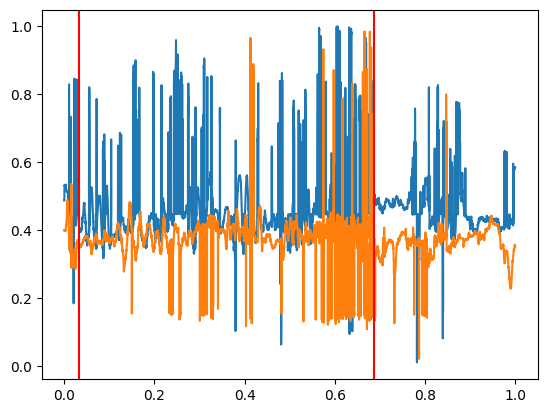

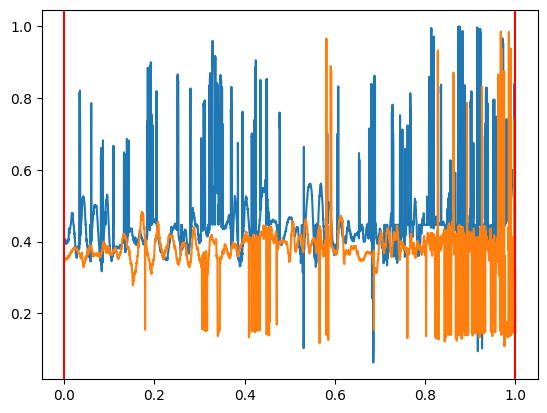

######## - Dupla1 - -1-t - ########


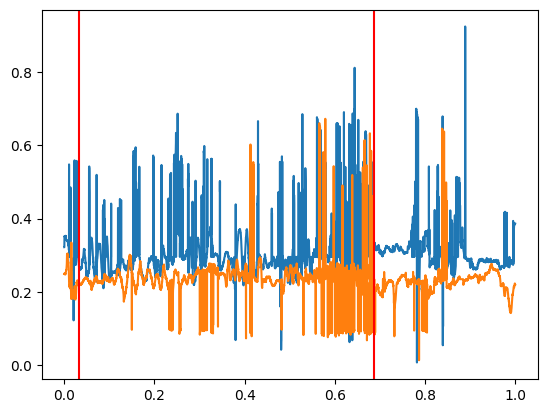

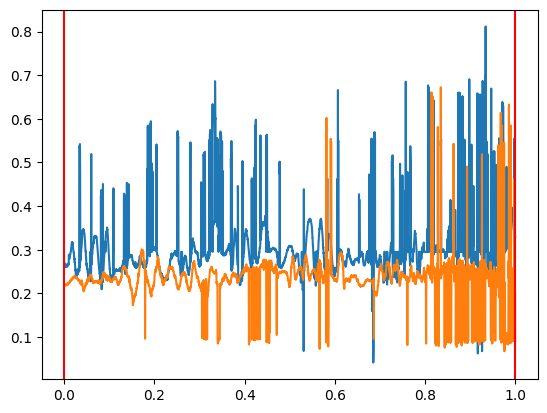

######## - Dupla2 - -0_5 - ########


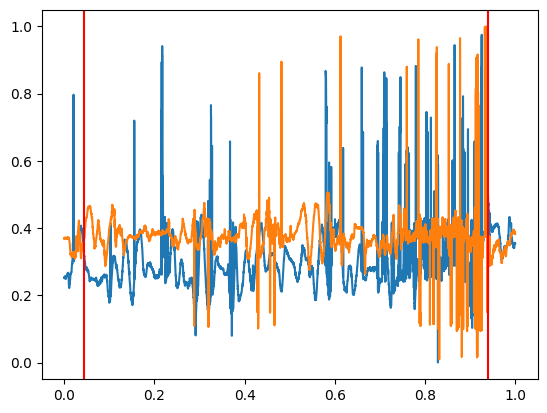

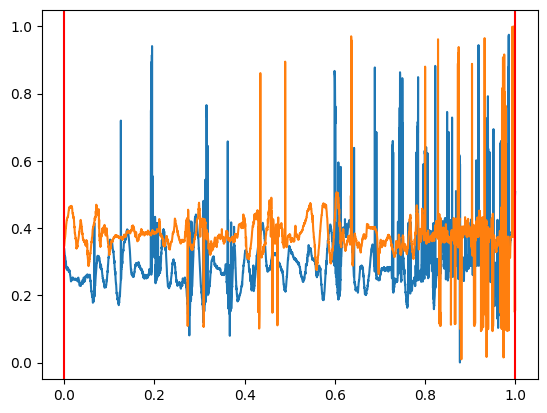

######## - Dupla2 - -1-t - ########


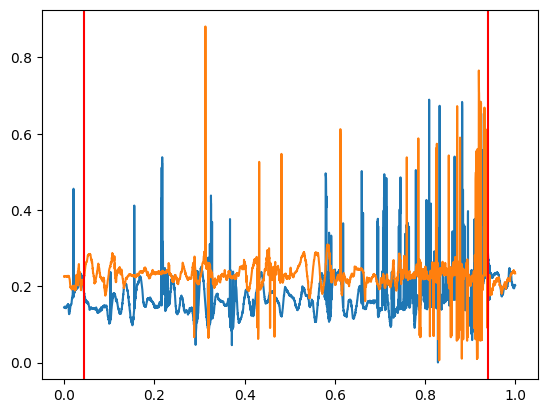

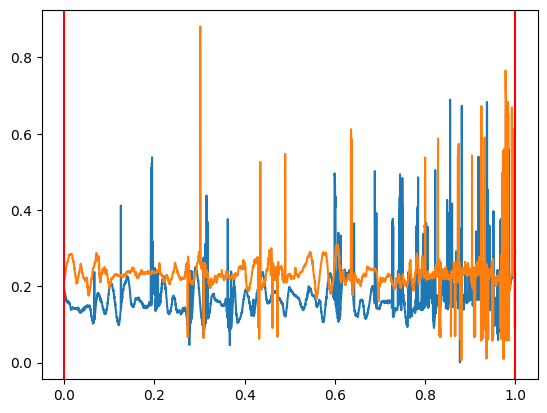

######## - Dupla3 - -0_5 - ########


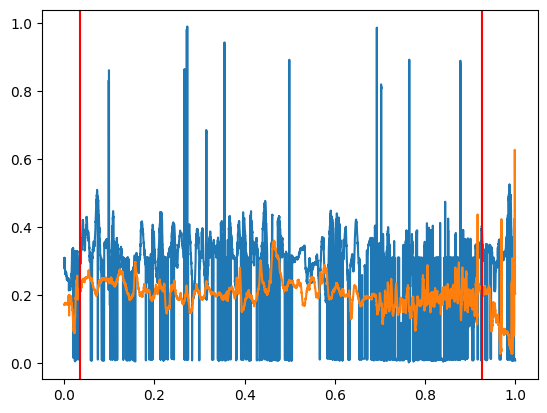

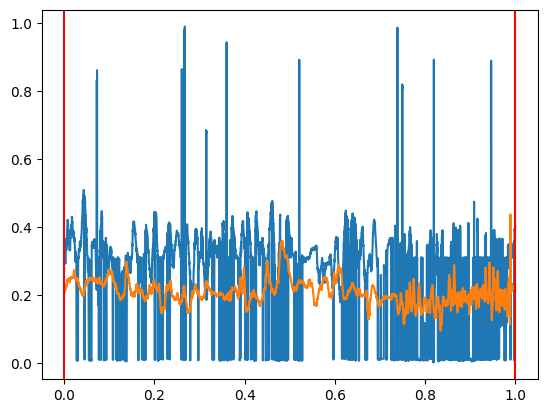

######## - Dupla3 - -1-t - ########


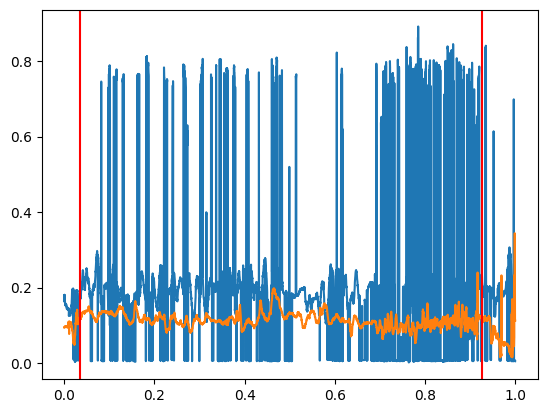

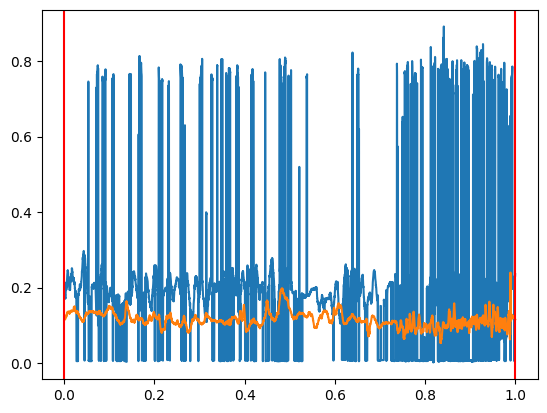

######## - Dupla5 - -0_5 - ########


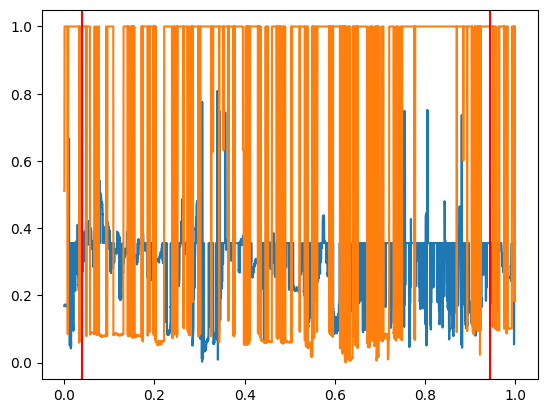

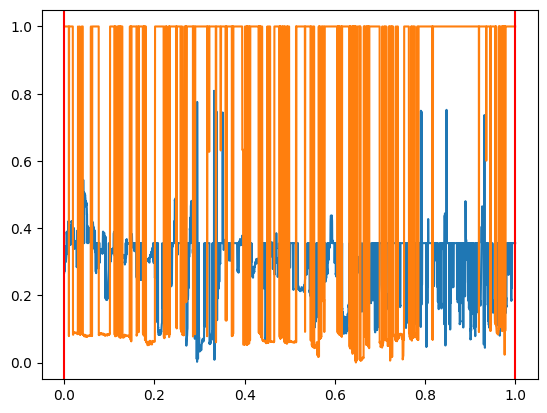

######## - Dupla5 - -1-t - ########


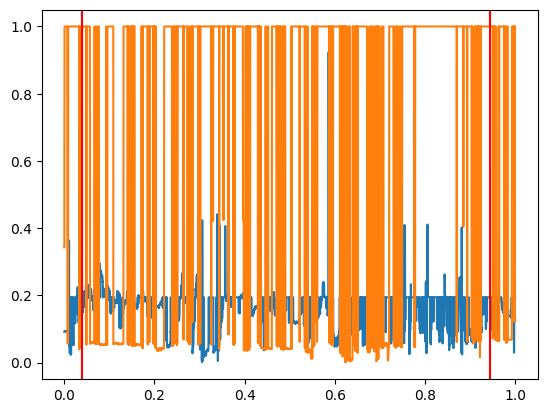

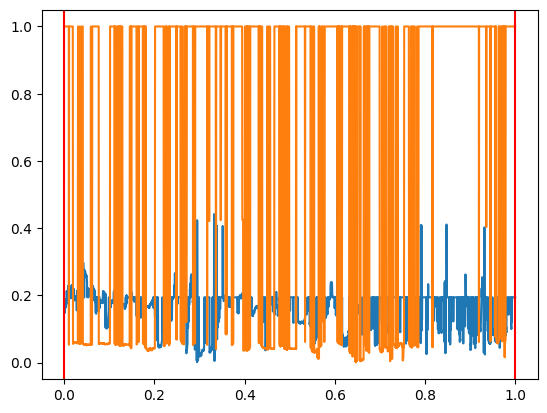

######## - Dupla6 - -0_5 - ########


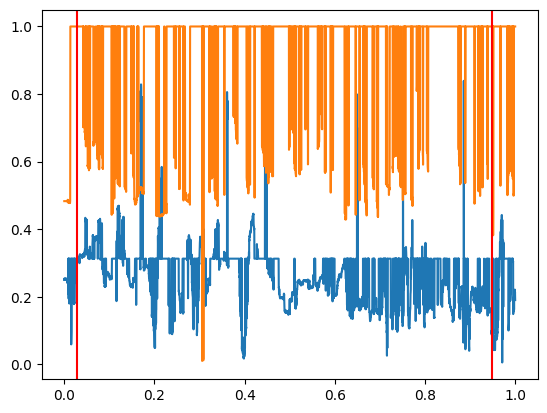

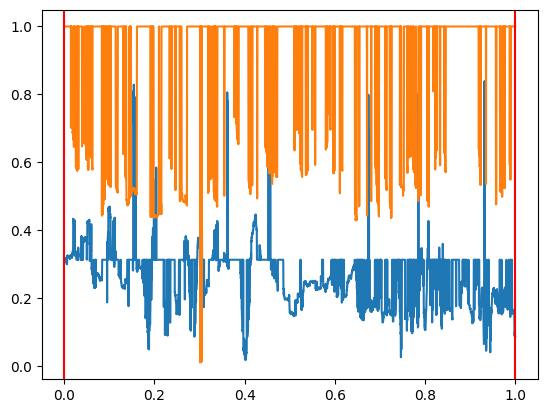

######## - Dupla6 - -1-t - ########


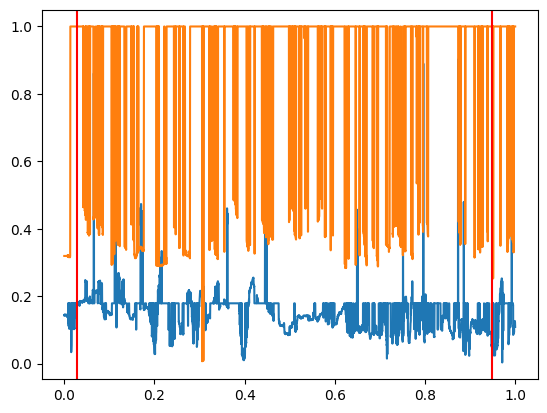

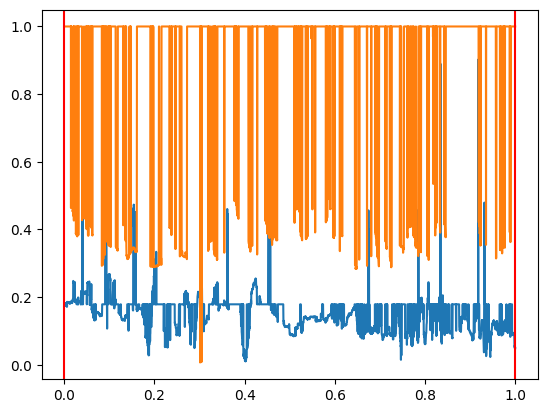

######## - Dupla7 - -0_5 - ########


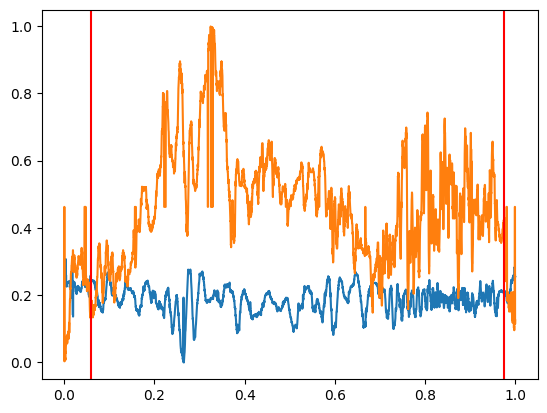

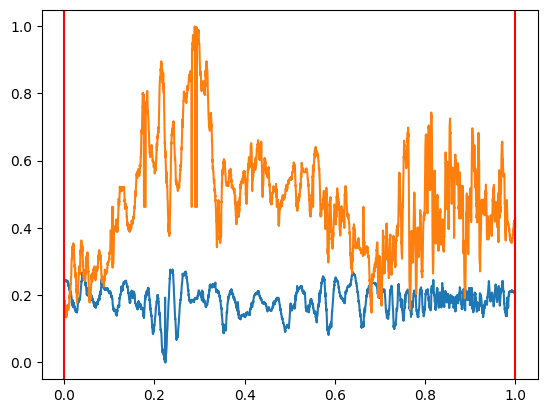

######## - Dupla7 - -1-t - ########


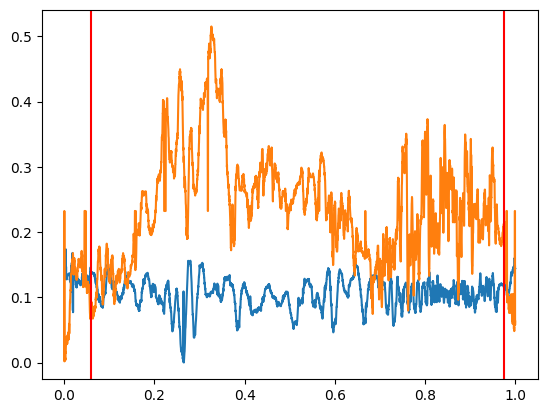

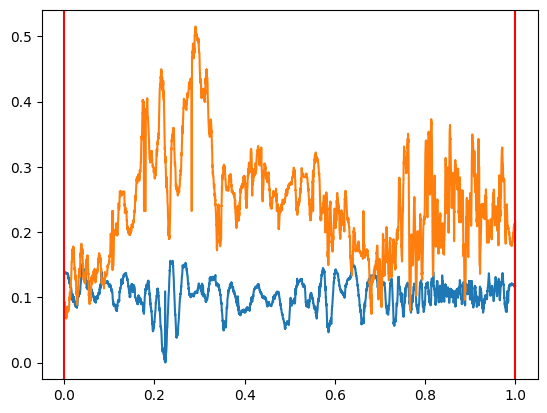

######## - Dupla8 - -0_5 - ########


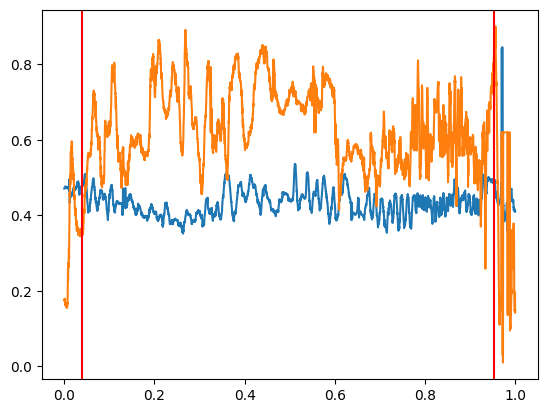

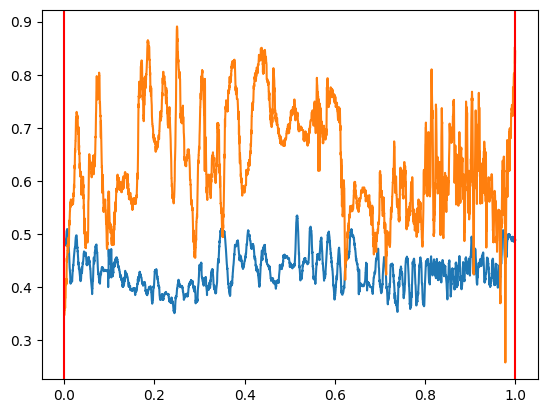

######## - Dupla8 - -1-t - ########


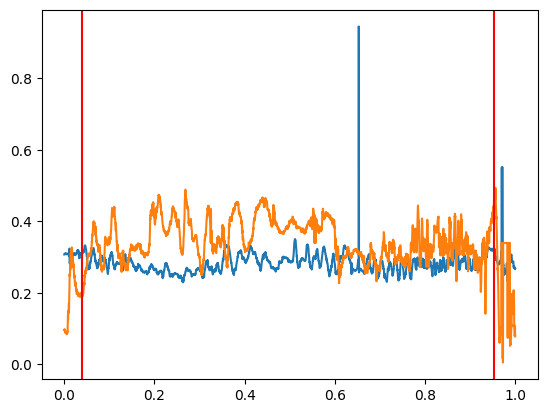

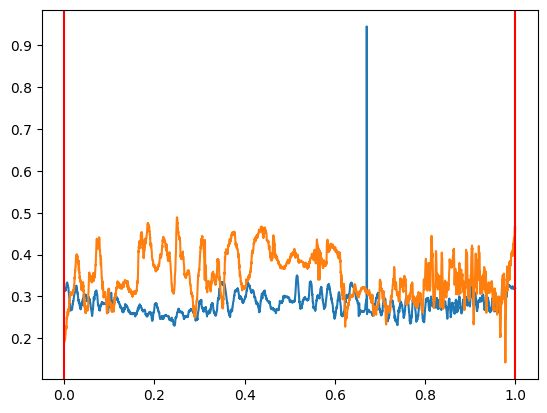

In [68]:
for file in files:
    
    df = pd.read_pickle(file)
    dupla = file[6:12]
    param = file[16:20]
    print(f"######## - {dupla} - {param} - ########")
    inicio = (tempos_duplas[dupla].values[1])/(tempos_duplas[dupla].values[11])
    fimPerf = (tempos_duplas[dupla].values[10])/(tempos_duplas[dupla].values[11])
    plt.clf()
    plt.plot(df.time,df[["motion_right_scaled_trat","motion_left_scaled_trat"]])
    plt.axvline(inicio,color="red")
    plt.axvline(fimPerf,color="red")
    plt.show()
    df2 = df[(df.time>=inicio) & (df.time<=fimPerf)].reset_index()
    df2["time_ajust"] = (df2.index+1)/len(df2)
    plt.clf()
    plt.plot(df2.time_ajust,df2[["motion_right_scaled_trat","motion_left_scaled_trat"]])
    df2.to_csv(f"Dados\\{dupla}{param}_tempo_ajustado.csv",index=False)
    plt.axvline(0,color="red")
    plt.axvline(1,color="red")
    plt.savefig(f"Figuras\\{dupla}_trat.png")
    plt.show()

Com isso temos novos arquivos gerados

In [69]:
files = glob.glob("Dados\\*.csv")
files

['Dados\\Dupla1-0_5_tempo_ajustado.csv',
 'Dados\\Dupla1-1-t_tempo_ajustado.csv',
 'Dados\\Dupla2-0_5_tempo_ajustado.csv',
 'Dados\\Dupla2-1-t_tempo_ajustado.csv',
 'Dados\\Dupla3-0_5_tempo_ajustado.csv',
 'Dados\\Dupla3-1-t_tempo_ajustado.csv',
 'Dados\\Dupla5-0_5_tempo_ajustado.csv',
 'Dados\\Dupla5-1-t_tempo_ajustado.csv',
 'Dados\\Dupla6-0_5_tempo_ajustado.csv',
 'Dados\\Dupla6-1-t_tempo_ajustado.csv',
 'Dados\\Dupla7-0_5_tempo_ajustado.csv',
 'Dados\\Dupla7-1-t_tempo_ajustado.csv',
 'Dados\\Dupla8-0_5_tempo_ajustado.csv',
 'Dados\\Dupla8-1-t_tempo_ajustado.csv']

In [70]:
exemplo = pd.read_csv(files[0])
exemplo

,index,motion_right,motion_left,motion_right_scaled,motion_left_scaled,time,motion_right_scaled_trat,motion_left_scaled_trat,time_ajust
0,209,323.691597,323.575725,0.409535,0.348211,0.032746,0.409535,0.348211,0.000238
1,210,322.534107,323.284704,0.406140,0.347171,0.032902,0.406140,0.347171,0.000477
2,211,322.615871,323.284704,0.406380,0.347171,0.033058,0.406380,0.347171,0.000715
3,212,322.586810,324.098750,0.406295,0.350079,0.033214,0.406295,0.350079,0.000953
4,213,321.459562,324.913835,0.402988,0.352992,0.033370,0.402988,0.352992,0.001192
...,...,...,...,...,...,...,...,...,...
4191,4400,351.482930,314.395054,0.491051,0.315409,0.686262,0.491051,0.315409,0.999047
4192,4401,352.115393,314.621201,0.492906,0.316217,0.686418,0.492906,0.316217,0.999285
4193,4402,352.363449,314.414138,0.493634,0.315477,0.686574,0.493634,0.315477,0.999523
4194,4403,352.296040,316.058934,0.493436,0.321354,0.686730,0.493436,0.321354,0.999762


Alguns tratamentos foram realizados sobre as séries para ter avaliações sobre o comportamento de cada dupla, uma delas foi construir a série média de cada performance, em que se tira o ponto médio de MA dos dois músicos participantes de cada performance

In [83]:
nomes = []
dados = []
analise = []
for file in files:
    df = pd.read_csv(file)
    direita = df.motion_right_scaled_trat
    esquerda = df.motion_left_scaled_trat
    nomes.append(f"D{file[11:12]}R")
    nomes.append(f"D{file[11:12]}L")
    dados.append(direita)
    dados.append(esquerda)
    analise.append([(direita+esquerda)/2,df.time_ajust])

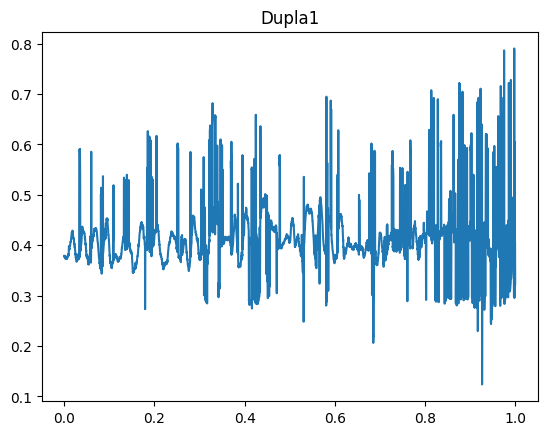

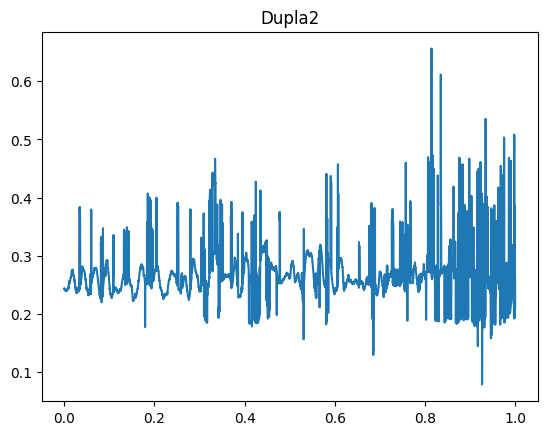

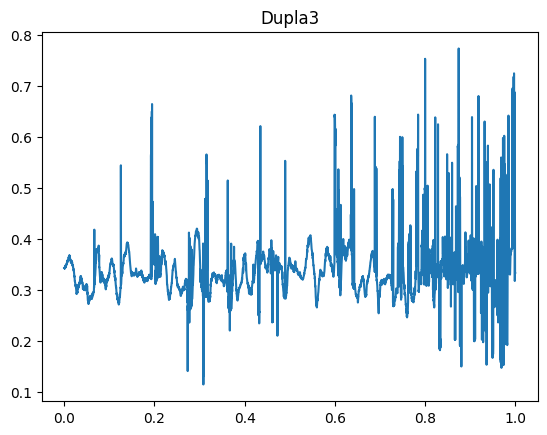

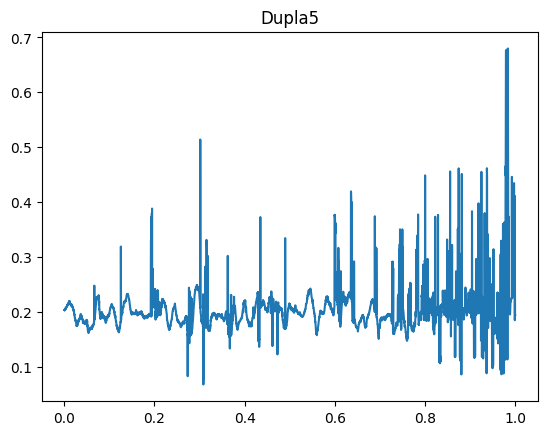

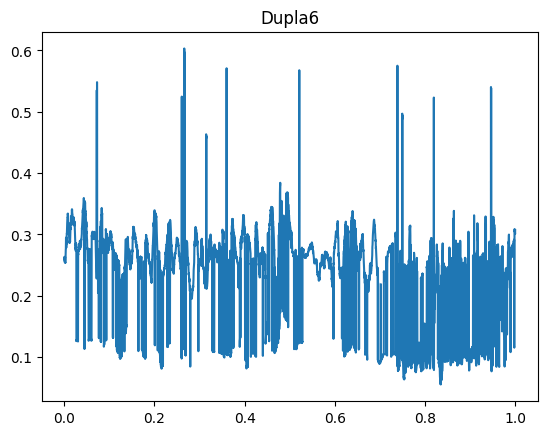

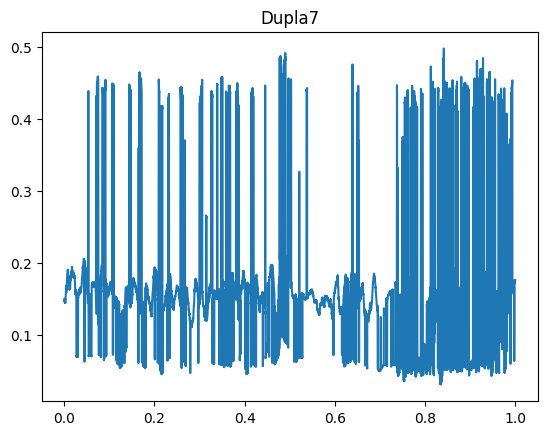

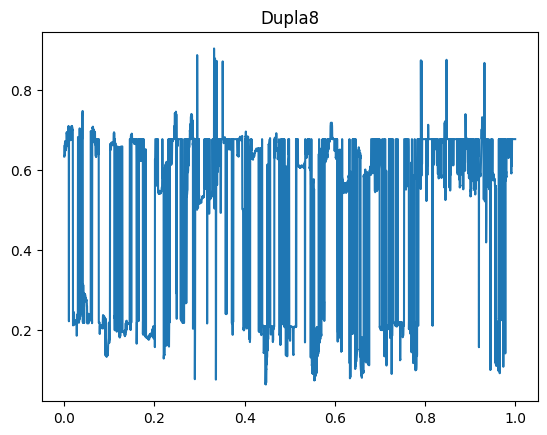

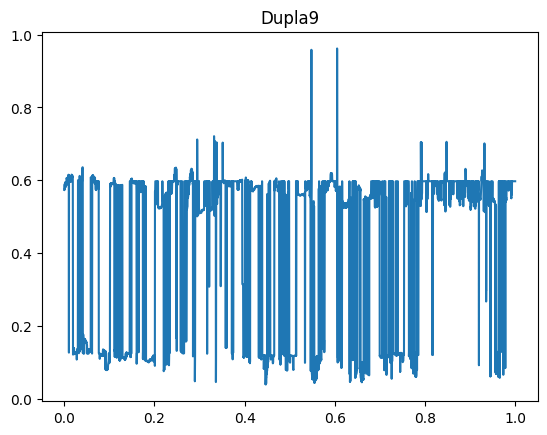

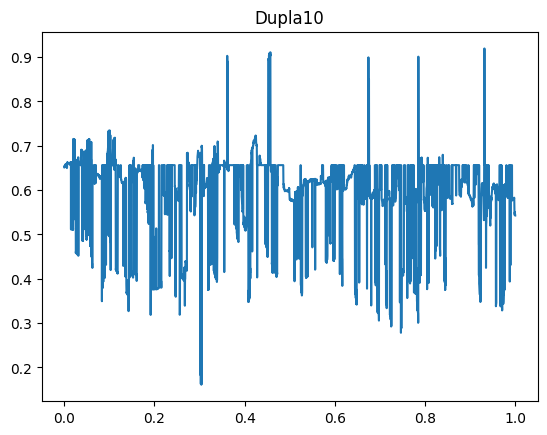

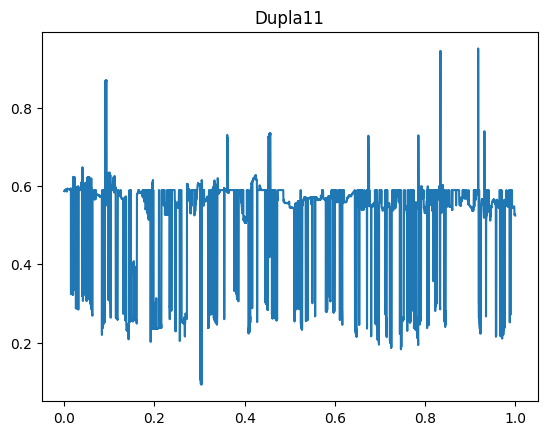

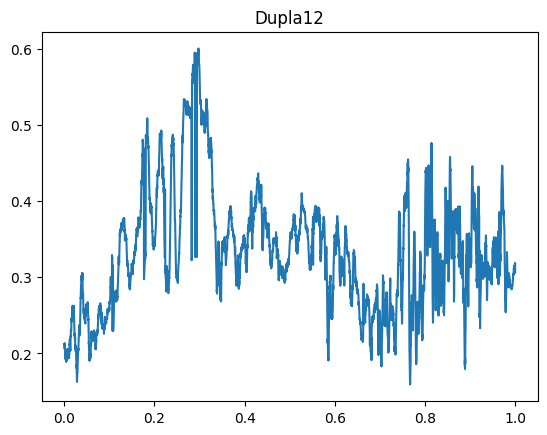

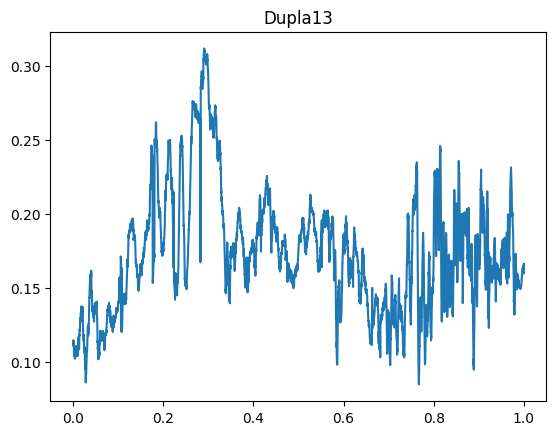

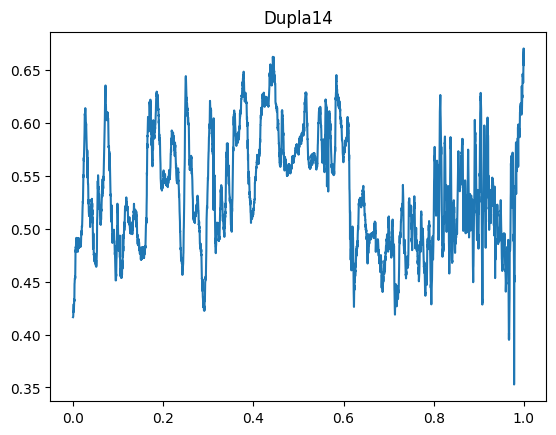

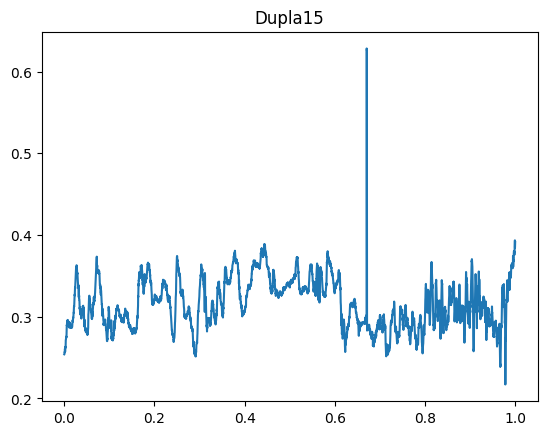

In [88]:
b=1

for a in analise:
    if b ==4:
        b=b+1
    plt.title(f"Dupla{b}")
    
    plt.plot(a[1],a[0])
    b=b+1
    plt.show()

Além disso a utilização de boxplots ajuda a visualizar a distribuição do movimento em cada dupla, facilitando na comparação do comportamento geral de cada músico permitindo visualizar qual se movimento mais em média do que outro

######## - Dupla1 - 0_5 - ########


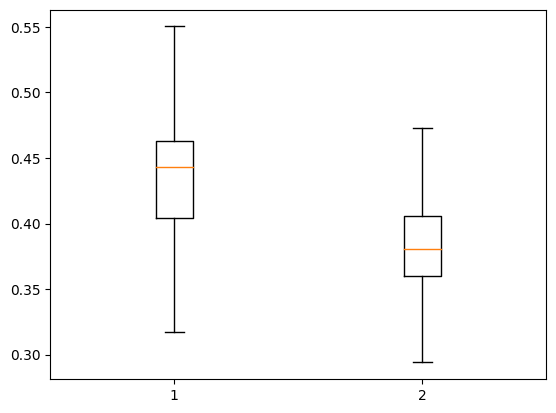

######## - Dupla1 - 1-t - ########


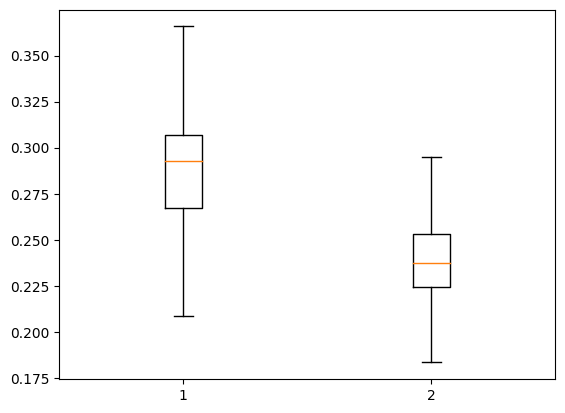

######## - Dupla2 - 0_5 - ########


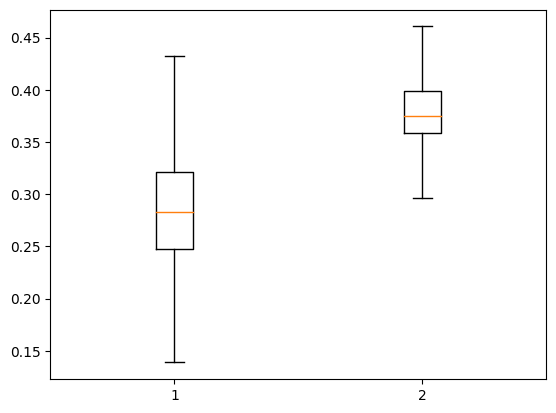

######## - Dupla2 - 1-t - ########


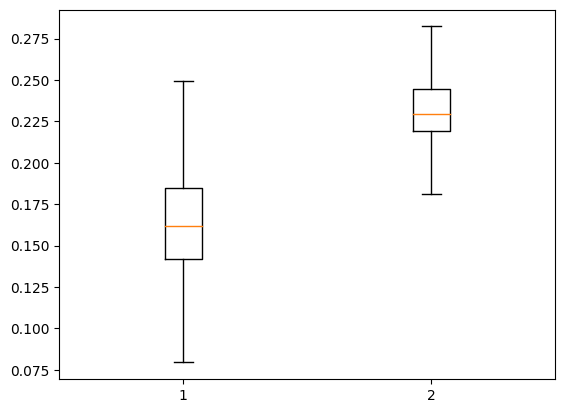

######## - Dupla3 - 0_5 - ########


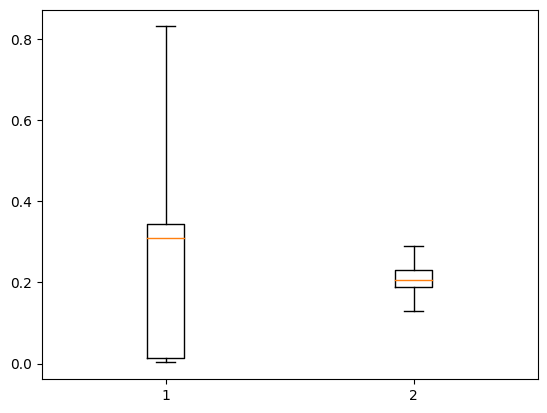

######## - Dupla3 - 1-t - ########


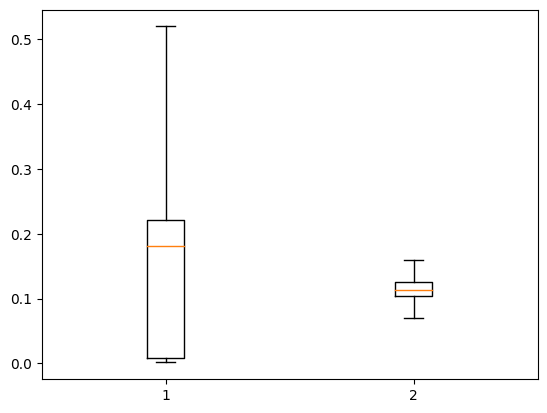

######## - Dupla5 - 0_5 - ########


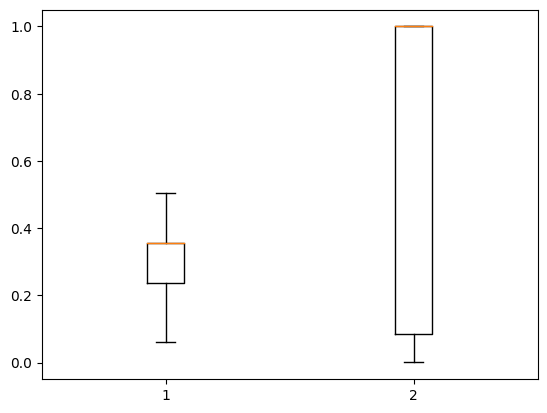

######## - Dupla5 - 1-t - ########


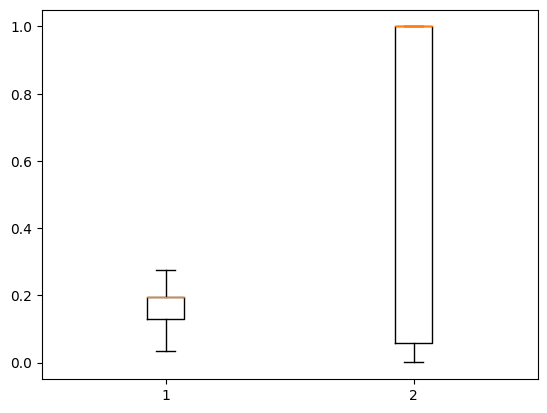

######## - Dupla6 - 0_5 - ########


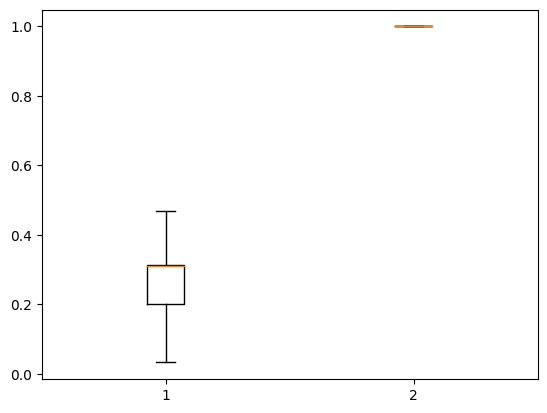

######## - Dupla6 - 1-t - ########


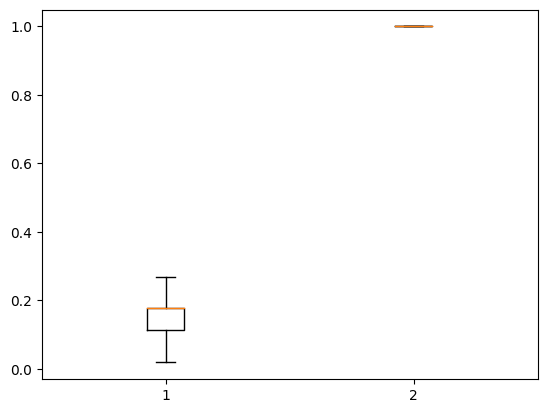

######## - Dupla7 - 0_5 - ########


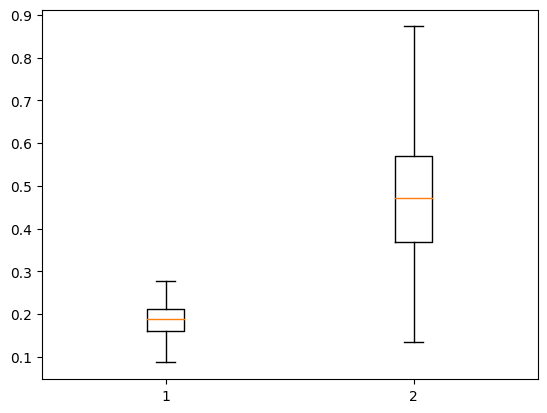

######## - Dupla7 - 1-t - ########


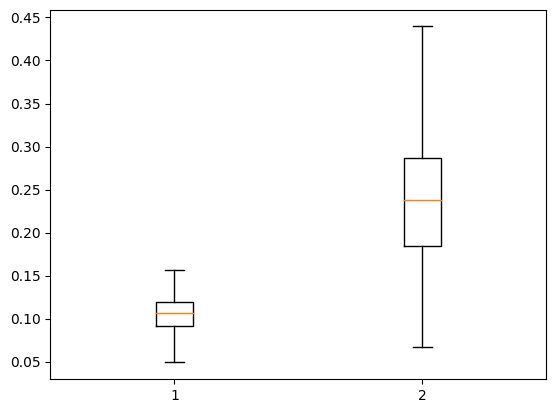

######## - Dupla8 - 0_5 - ########


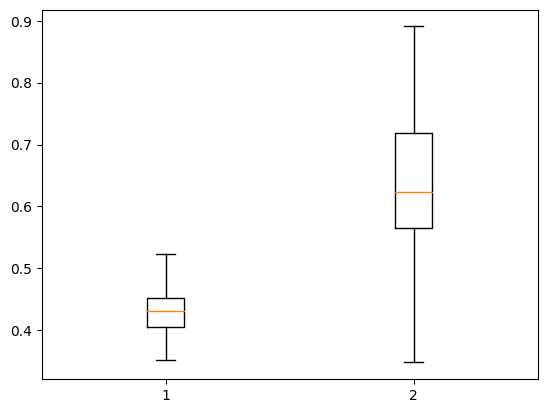

######## - Dupla8 - 1-t - ########


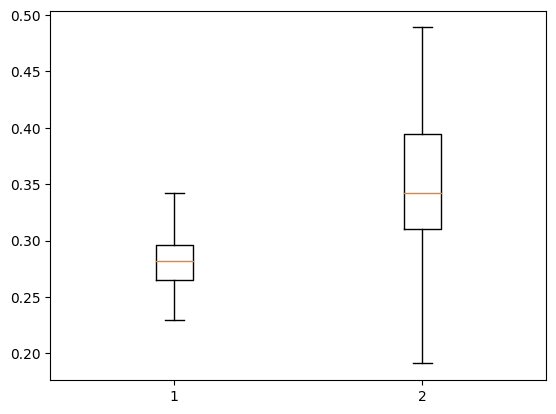

In [93]:
for file in files:
    
    df = pd.read_csv(file)
    dupla = file[6:12]
    param = file[13:16]
    print(f"######## - {dupla} - {param} - ########")
    plt.boxplot(df[['motion_right_scaled_trat', 'motion_left_scaled_trat']],showfliers=False,meanline=True)
    plt.show()

Outro ponto importante das análises foi tentar observar como a serie de um músico impacta a série de seu duo na performance, para isso foi utilizado um teste de causalidade de granger por meio desse teste podemos inferir um p-valor que nos ajuda a rejeitar uma hipótese inicial e propor uma hipótese alternativa. Esse teste propõe as seguintes hipoteses:

**Hipótese Nula (H0):** A série temporal X Não tem correlação de grage sobre a série temporal Y

**Hipótese Alternativa (HA):** A série Temporal X Granger-causes a série temporal Y

O teste produz um F teste estatístico com um p-valor associado. Se esse p-valoes é menor que um determinado grau de confiança (i.e. α = .05), entao podemos rejeitar a hipotese Nula e concluir que temos certa evidência para a hipótese alternativa, ou seja dizer que conhecendo a serie X com um determinado atraso podemos tentar prever a série Y. 

Em especial para nosso problema vamos testar em ambas as direções ou seja prever X com Y e Y com X, porém um caso só é interessante quando possuir p-valor significativo em apenas uma das direções.

In [94]:
from statsmodels.tsa.stattools import grangercausalitytests

In [95]:
for file in files:
    
    df = pd.read_csv(file)
    dupla = file[6:12]
    param = file[13:16]
    print(f"######## - {dupla} - {param} - ########")
    
    aa=grangercausalitytests(df[['motion_right_scaled_trat', 'motion_left_scaled_trat']], maxlag=[10])
    
    bb=grangercausalitytests(df[['motion_left_scaled_trat', 'motion_right_scaled_trat']], maxlag=[10])

######## - Dupla1 - 0_5 - ########

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4631  , p=0.0062  , df_denom=4165, df_num=10
ssr based chi2 test:   chi2=24.7550 , p=0.0058  , df=10
likelihood ratio test: chi2=24.6820 , p=0.0060  , df=10
parameter F test:         F=2.4631  , p=0.0062  , df_denom=4165, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3756  , p=0.0084  , df_denom=4165, df_num=10
ssr based chi2 test:   chi2=23.8762 , p=0.0079  , df=10
likelihood ratio test: chi2=23.8084 , p=0.0081  , df=10
parameter F test:         F=2.3756  , p=0.0084  , df_denom=4165, df_num=10
######## - Dupla1 - 1-t - ########

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.7856  , p=0.0000  , df_denom=4165, df_num=10
ssr based chi2 test:   chi2=48.0975 , p=0.0000  , df=10
likelihood ratio test: chi2=47.8233 , p=0.0000  , df=10
parameter F test:         F=4.7856  , p=0.0000  , df_denom=4165, df_num=10

Gr

Foi utilizado um lag de 10, porém será interessante fazer testes com diferentes atrasos para tentar discorrer sobre em que momento o movimento de um músico interfere no seu duo

# Conclusão

De forma geral é possível concluir que a captura de movimentos ocorreu de forma consistente e assertiva nas duplas, mostrando que esse método é uma solução interessante para a resolução desse problema. O código também apresentou bom desempenho em vídeos nos quais havia a presença de objetos obstruindo os pontos de interesse nas imagens, permitindo ainda assim identificar o movimento de cada um dos participantes ao longo do tempo. O projeto poderá ser utilizado em futuros testes como um método de suporte para análise dos dados de experimentos com músicos.